<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Introduction to Decision Trees & Random Forests

## Icebreaker

Today we're talking about **decisions**. With your neighbour discuss the following question:

#### How do humans make decisions?

If you wanted to decide whether or not to go to the pub after work to watch the football (let's assume you actually like it...!) - what does that decision-making process look like?

## Housekeeping

- submitting your project update: let both me and your TA know on Slack!

- Unit 3 project due **end of next week**

- welcome to our visiting Data Scientists!

## Agenda

#### Making Decisions

#### Representing Decisions Visually

#### Decision Trees

- what they are
- how they're constructed

#### Decision Trees in Python

#### Random Forests

#### Panel Discussion

# Making Decisions

Our previous machine learning models were based on fitting lines, and averaging "similar" data points

But Data Science is about helping people make better decisions

So why not build a model that mimics decision-making?

One aspect of decision-making is creating **rules**

"**If** it's raining, **and** my friends aren't going to the game, **then** I won't go either"

How would we represent these rules **visually**?

### Flowcharts!

![](assets/images/xkcd_flowchart.png)

[xkcd #1195](https://xkcd.com/1195)

![](assets/images/pub_decision_tree.png)

![](assets/images/decision_tree_terminology.png)

from [https://medium.com/greyatom/decision-tree-intuition-a38669005cb7](https://medium.com/greyatom/decision-tree-intuition-a38669005cb7)

How do we decide what order we ask questions?

- we want to put the "most important" questions at the top

- if rain means we stay at home **no matter what**, it's the first question we should ask

## Exercise

With your neighbour, draw a decision tree for the following problem:

Should I sell my existing car and buy a new one?

Factors to consider:

- how big is my budget? (options: BIG / SMALL)
- is there anything wrong with my current car? (options: YES / NO)
- is the new car expensive? (options: YES / NO)

Order your questions by importance!

### Decision trees for prediction

Instead of coming up with the rules ourselves, we want to **automatically learn** the decision tree that gives us the best predictions

We want to learn the best if-then rules that give us leaves where we output the correct predictions

Remember when we eyeballed the iris data to come up with the classifier?

Well that's what we want to automate!

### "Importance"

How can we decide which question is the best one to ask?

It should be the one that **gives us the most new information**

In the case of **regression**, we can use the Mean Squared Error

In the case of **classification**, this means separating the classes better

Specifically in classification trees we want to minimise the "Gini impurity"

This is a measure of how "pure" the class labels are in a leaf

It reaches its minimum, 0, when all items are the same class

In [1]:
# quick code to load iris and train a tree
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris

%matplotlib inline

iris = load_iris()

df = pd.DataFrame(iris.data, columns=iris.feature_names)
df["target"] = iris.target
df["target"] = df["target"].map({idx:name for idx, name in enumerate(iris.target_names)})

df_binary_iris = df[df["target"] != "virginica"]

from sklearn.tree import DecisionTreeClassifier, export_graphviz

dt = DecisionTreeClassifier(max_depth=1)
dt.fit(df_binary_iris[iris.feature_names], df_binary_iris["target"])
export_graphviz(dt, "iris.dot", feature_names=iris.feature_names)

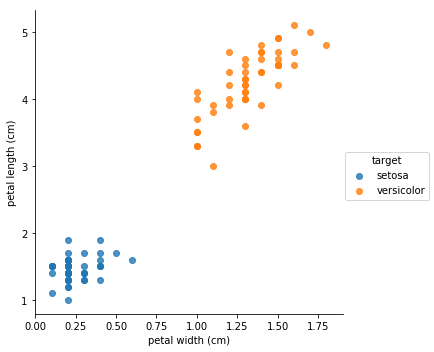

In [2]:
sns.lmplot(x="petal width (cm)", y="petal length (cm)", data=df_binary_iris, fit_reg=False, hue="target");

![](assets/images/iris_tree.png)

Decision trees just "carve up" the space:

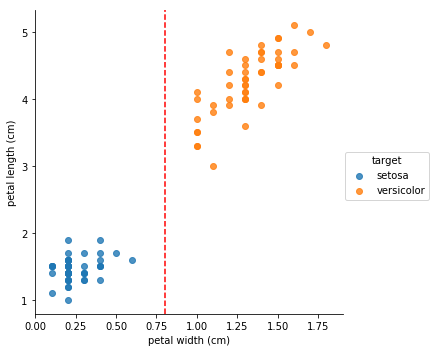

In [4]:
sns.lmplot(x="petal width (cm)", y="petal length (cm)", data=df_binary_iris, fit_reg=False, hue="target")
plt.axvline(0.8,c="r",linestyle="dashed");

In [5]:
from sklearn.metrics import accuracy_score

dt = DecisionTreeClassifier(max_depth=3)
dt.fit(df[iris.feature_names], df["target"])
print(accuracy_score(df["target"], dt.predict(df[iris.feature_names])))
export_graphviz(dt, "iris_3_class.dot", feature_names=iris.feature_names)

0.9733333333333334


<h4>97% Accuracy (3 classes)</h4>

![](assets/images/iris_tree_complex.png)

### Decision Tree Algorithm

- pick the "best" feature to split on

- keep splitting on the "best" available feature

- stop at some point

#### Stopping Criteria

How do we know when do we stop?

- when a leaf is "pure" e.g. we've created a split where a leaf only contains one class

- we can also specify the maximum tree depth and minimum samples that have to be in a leaf

- what are "maximum tree depth" and "minimum samples per leaf" examples of?

In [6]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(max_depth=3)

dt.fit(df[iris.feature_names], df["target"])

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

#### Visualise our tree

In [8]:
from sklearn.tree import export_graphviz

export_graphviz(dt, "iris.dot", feature_names=iris.feature_names)

Paste into [webgraphviz.com](http://www.webgraphviz.com/)

# Pros & Cons

### Pros

- intuitive to explain & understand (if the tree isn't huge!)

- gives us an intuition about feature importance

- prediction is fast

- doesn't make assumptions e.g. linearity

- do we need to scale features?

### Cons

- easily overfits, needs tuning

- high variance algorithm, sensitive to changes in training data

- typically doesn't perform as well as other algorithms

# Random Forests

Idea: instead of thinking a single model will solve all our problems, why not try **many** models?

This is called **ensembling** (and it's how you win Kaggle competitions)

![](assets/images/kaggle_ensemble.jpg)

from [http://blog.kaggle.com/2016/04/08/homesite-quote-conversion-winners-write-up-1st-place-kazanova-faron-clobber](http://blog.kaggle.com/2016/04/08/homesite-quote-conversion-winners-write-up-1st-place-kazanova-faron-clobber)

The idea behind ensembling is that while individual models may be pretty bad...

... their average predictions are better than a single model

If we do this with lots of small, bad decision trees, we get a good model!

This is the essence of a **random forest**

Random forests make use of **bagging** ("bootstrap aggregation")

These are **bootstrapped samples** (samples of our training set **with replacement**)

This reduces variance, which means less overfitting

Each tree in a random forest uses a **random set of features** from the training set

This avoids the same tree being constructed each time (which would happen if one feature is "good" by our measure of importance)

In [9]:
baseball = pd.read_csv("assets/data/hitters.csv")
baseball = baseball[baseball["Salary"].isnull() == False]
baseball.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N
5,594,169,4,74,51,35,11,4408,1133,19,501,336,194,A,W,282,421,25,750.0,A


In [11]:
import numpy as np

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score

X = baseball[["HmRun", "Years", "Errors"]]
y = baseball["Salary"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

dt = DecisionTreeRegressor(min_samples_leaf=5)
rf = RandomForestRegressor(n_estimators=11, min_samples_leaf=5)

In [12]:
dt_scores = cross_val_score(dt, X_train, y_train, cv=10, scoring="neg_mean_squared_error")
rf_scores = cross_val_score(rf, X_train, y_train, cv=10, scoring="neg_mean_squared_error")

print("RMSE (decision tree): {0}\nRMSE (random forest): {1}".format(np.sqrt(np.mean(-dt_scores)),
                                                                    np.sqrt(np.mean(-rf_scores))))

RMSE (decision tree): 356.45087906321174
RMSE (random forest): 343.05295506459476


In [13]:
print("Decision tree scores:\n", np.sqrt(-dt_scores))
print("\nRandom forest scores:\n", np.sqrt(-rf_scores))

Decision tree scores:
 [431.43902137 249.37775685 443.89997468 446.05827951 362.84101319
 248.37951179 463.0301784  296.37706649 252.63488002 258.49863413]

Random forest scores:
 [362.63902435 284.08609509 445.76275635 414.36209274 357.98378172
 180.64585034 428.15647401 328.20749873 259.26452756 274.22511664]


#### Bonus!

In [14]:

rf = RandomForestRegressor()
rf.fit(X_train, y_train)

for z in zip(X_train.columns, rf.feature_importances_):
    print(z)

('HmRun', 0.37929009709957695)
('Years', 0.45146945786168813)
('Errors', 0.16924044503873495)


Obligatory StackOverflow thread where people decipher what this does under the hood: [https://stackoverflow.com/questions/15810339/how-are-feature-importances-in-randomforestclassifier-determined](https://stackoverflow.com/questions/15810339/how-are-feature-importances-in-randomforestclassifier-determined)

# Exercise